In [1]:
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras import backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import TensorBoard,ModelCheckpoint
#_optimizer = Adam(0.0002, 0.9)
_optimizer = Adam(0.001, 0.9, decay=0.0001)
from tensorflow.python.keras import losses

# from tensorflow.keras import layers
# from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# from IPython import display
from tqdm import tqdm
import os

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

#!ls "/content/drive/My Drive"

In [3]:
def encoder_block(_filters, _kernel_size, _strides, bn = True):
    y = Sequential()
    y.add(layers.Conv2D(filters = _filters, kernel_size = _kernel_size, 
                      strides = _strides, padding="same",
                      kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.02)))
    if bn is True:
        y.add(layers.BatchNormalization(momentum = 0.9, epsilon=1e-5))
    y.add(layers.ReLU())
    return y

In [4]:
def decoder_block(_filters, _kernel_size, _strides, dropout = False):
    y = Sequential()
    y.add(layers.Conv2DTranspose(filters = _filters, kernel_size = _kernel_size,
                               strides=_strides, padding="same",
                               kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02)))
    y.add(layers.BatchNormalization(momentum = 0.9, epsilon=1e-5))
    if dropout is True:
        y.add(layers.Dropout(0.5))
    y.add(layers.ReLU())
    return y

In [5]:
# def fcn():
#     inputs = layers.Input(shape=(256, 256, 3))
#     enc1 = encoder_block(32, (5, 5), (4, 4), bn = False)(inputs)
#     dec1 = decoder_block(16, (5, 5), (4, 4))(enc1)
#     model = Model(inputs=inputs, outputs=dec1)
#     return model

# img1 = layers.Input(shape=(256, 256, 3))
# img2 = layers.Input(shape=(256, 256, 3))
# Layer = fcn()
# a1 = Layer(img1)
# a2 = Layer(img2)
# b = layers.Concatenate()([a1, a2])
# model = Model(inputs = [img1, img2], outputs = b)
# model.summary()

In [6]:
def encoder_net():
    inputs = layers.Input(shape=(None, None, 3))
    enc1 = encoder_block(32, (5, 5), (4, 4), bn = False)(inputs)
    enc2 = encoder_block(128, (5, 5), (4, 4))(enc1)
    enc3 = encoder_block(128, (5, 5), (4, 4))(enc2)
#     enc4 = encoder_block(256, (5, 5), (4, 4))(enc3)
    
#     dec1 = decoder_block(2, (5, 5), (4, 4))(enc4)
#     dec1 = layers.Concatenate(axis = -1)([enc3, dec1])
    dec2 = decoder_block(2, (5, 5), (4, 4))(enc3)
    dec2 = layers.Concatenate()([enc2, dec2])
    dec3 = decoder_block(2, (5, 5), (4, 4), False)(dec2)
    dec3 = layers.Concatenate()([enc1, dec3])
    dec4 = decoder_block(2, (5, 5), (4, 4))(dec3)
    dec4 = layers.Concatenate()([inputs, dec4])
    
    model = Model(inputs = inputs, outputs = dec4)
    return model

In [7]:
def decoder_net(Enc):
    inputs = layers.Input(shape=(None, None, 10))

#     dec1 = decoder_block(256, (5, 5), (4, 4))(inputs)
#     dec1 = layers.Concatenate(axis = -1)([Enc.layers[-1], dec1])
#     dec2 = decoder_block(256, (5, 5), (4, 4), False)(dec1)
#     dec2 = layers.Concatenate()([Enc.layers[-1], dec2])
#     dec3 = decoder_block(128, (5, 5), (4, 4), False)(dec2)
#     dec3 = layers.Concatenate()([Enc.layers[-1], dec3])
#     dec4 = decoder_block(32, (5, 5), (4, 4), False)(dec3)
#     dec4 = layers.Concatenate()([Enc.layers[-1], dec4])
    dec5 = encoder_block(8, (5, 5), (1, 1), bn = False)(inputs)
    dec6 = layers.Conv2D(filters = 1, kernel_size = (5, 5), padding = "same",
                      activation="tanh",
                      kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.02))(dec5)
    model = Model(inputs = inputs, outputs = dec6)
    return model

In [8]:
def fusionnet(inTensor1, inTensor2):
    Enc = encoder_net()
    out1 = Enc(inTensor1)
    out2 = Enc(inTensor2)
    x = layers.Concatenate(axis = -1)([out1, out2])
    y = decoder_net(Enc)(x)
    return y

In [9]:
def fusionnetPos(y):
    y, inTensor1, inTensor2 = y
    y = K.tile(y, [1, 1, 1, 3])
    y1 = layers.Multiply()([inTensor1, (1+y)/2])
    y2 = layers.Multiply()([inTensor2, 1-(1+y)/2])
    y = layers.Add()([y1, y2])
#     y1 = inTensor1*((1+y)/2)
#     y2 = inTensor2*(1-(1+y)/2)
#     y = y1+y2
    return y

In [10]:
img1 = layers.Input(shape=(None, None, 3))
img2 = layers.Input(shape=(None, None, 3))
intermed = fusionnet(img1, img2) # intermed: mask layer

pred = layers.Lambda(fusionnetPos)([intermed, img1, img2])

In [11]:
'''2 outputs: 'pred' for GAN loss and 'intermed' for mask loss'''
generator = Model(inputs = [img1, img2], outputs = [pred, intermed])
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, None, None, 5 530342      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, None, None, 1 0           model[1][0]                      
          

In [12]:
def load_imgs(path, number, train_type):
    result1=np.zeros((number, 256, 256, 3), dtype=np.uint8)
    result2=np.zeros((number, 256, 256, 3), dtype=np.uint8)
    result0=np.zeros((number, 256, 256, 3), dtype=np.uint8)

    i = 0
    while i < number:
        img_idx = 1+np.random.randint(1454)
        I1 = cv2.imread(path + "{:04}_{}.png".format(img_idx, 1))
        I2 = cv2.imread(path + "{:04}_{}.png".format(img_idx, 2))
        I0 = cv2.imread(path + "{:04}_{}.png".format(img_idx, 0))        
        if I0 is None or min(I0.shape[:2]) < 256:
            continue
        m, n = I0.shape[:2]
        m_b = np.random.randint(m-255)
        n_b = np.random.randint(n-255)
        result1[i, :, :, :] = I1[m_b:m_b+256, n_b:n_b+256, :]
        result2[i, :, :, :] = I2[m_b:m_b+256, n_b:n_b+256, :]
        result0[i, :, :, :] = I0[m_b:m_b+256, n_b:n_b+256, :]
        i += 1
    return result1, result2, result0

In [13]:
path = 'ImagePair/'
num = 5000

x1, x2, y = load_imgs(path, num, 1)

    
x_train1, x_test1, x_train2, x_test2, y_train, y_test = train_test_split(
    x1, x2, y, test_size=0.2, random_state=7412)

In [14]:
# idx = 121
# plt.imshow(x_train1[idx, :, :, :])
# plt.show()
# plt.imshow(x_train2[idx, :, :, :])
# plt.show()
# plt.imshow(y_train[idx, :, :, :])
# plt.show()

In [15]:
def data_aug(img):
    # normalization
    # change constract/brightness inside pair
    # add noise
    # change color
    pass
    

In [16]:
def data_gen(features, labels, batch_size):
    features1, features2 = features
 # Create empty arrays to contain batch of features and labels#
    batch_features1 = np.zeros((batch_size, 256, 256, 3))
    batch_features2 = np.zeros((batch_size, 256, 256, 3))
    batch_labels = np.zeros((batch_size, 256, 256, 3))
    while True:
        for i in np.arange(0, features1.shape[0] - batch_size, batch_size):
            # choose random index in features
            batch_features1 = features1[i:i+batch_size, :, :, :].astype('float16')/127.5-1
            batch_features2 = features2[i:i+batch_size, :, :, :].astype('float16')/127.5-1
            batch_labels= labels[i:i+batch_size, :, :, :].astype('float16')/127.5-1
            batch_masks = np.zeros((batch_size, 256, 256, 1))
            yield ([batch_features1, batch_features2], [batch_labels, batch_masks])

In [17]:
def tv_loss(y_true, y_pred):
    mapping = tf.square(y_pred+1)*tf.square(y_pred-1)/(tf.square(y_pred)+1)
    loss = tf.reduce_mean(mapping)
    return loss

In [18]:
# tcbc = TensorBoard(log_dir='1')
# filepath="models/{epoch:03d}-{val_loss:.5f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',period=1)

In [19]:
batch_size = 16
epochs = 30
generator.compile(loss=['mse',tv_loss],loss_weights=[1, 1e-2], optimizer= _optimizer)
history = generator.fit_generator(data_gen([x_train1, x_train2], y_train, batch_size), 
                    steps_per_epoch = x_train1.shape[0]//batch_size, epochs = epochs,
                    validation_data=data_gen([x_test1, x_test2], y_test, batch_size), 
                    validation_steps = batch_size,verbose=1)#, callbacks = [tcbc, checkpoint])

Epoch 1/30
250/250 [==============================] - 47s 189ms/step - loss: 0.0848 - lambda_loss: 0.0802 - model_1_loss: 0.4632 - val_loss: 0.0449 - val_lambda_loss: 0.0424 - val_model_1_loss: 0.2522
Epoch 2/30
250/250 [==============================] - 45s 179ms/step - loss: 0.0409 - lambda_loss: 0.0386 - model_1_loss: 0.2238 - val_loss: 0.0431 - val_lambda_loss: 0.0415 - val_model_1_loss: 0.1658
Epoch 3/30
250/250 [==============================] - 45s 179ms/step - loss: 0.0326 - lambda_loss: 0.0310 - model_1_loss: 0.1642 - val_loss: 0.0306 - val_lambda_loss: 0.0288 - val_model_1_loss: 0.1778
Epoch 4/30
250/250 [==============================] - 45s 179ms/step - loss: 0.0278 - lambda_loss: 0.0264 - model_1_loss: 0.1320 - val_loss: 0.0233 - val_lambda_loss: 0.0221 - val_model_1_loss: 0.1225
Epoch 5/30
250/250 [==============================] - 45s 179ms/step - loss: 0.0251 - lambda_loss: 0.0240 - model_1_loss: 0.1154 - val_loss: 0.0241 - val_lambda_loss: 0.0230 - val_model_1_loss: 0.

In [20]:
# generator.load_weights('models/g.h5')

In [21]:
# from keras.models import load_model
# #from keras import layers
# load_model('models/g.h5')

In [22]:
# I1 = cv2.imread('/home/qian/Documents/FusionNet/1.jpg')
# I2 = cv2.imread('/home/qian/Documents/FusionNet/2.jpg')
# I1 = cv2.resize(I1,(640, 360))
# I2 = cv2.resize(I2,(640, 360))
# print(I1.shape)
# print(I1.max())

# I1 = I1[np.newaxis, :320, :, :]/127.5-1
# I2 = I2[np.newaxis, :320, :, :]/127.5-1
# pred, mask = generator.predict([I1, I2])
# plt.imshow((pred[0, :, :, ::-1]+1)/2)
# cv2.imwrite('b.jpg',(((pred[0, :, :, :]+1)/2)*255).astype('uint8'))
# cv2.imwrite('c.jpg',((I1[0, :, :, :]+I2[0, :, :, :]+2)/4*255).astype('uint8'))
# cv2.imwrite('m.jpg',(((mask[0, :, :, :]+1)/2)*255).astype('uint8'))

In [23]:
# # generator.save('models/g.h5')
# generator.layers[-2].get_output_at(-1)

In [24]:
prediction, temp= generator.predict([x_test1[:25, :, :, :]/127.5-1, x_test2[:25, :, :, :]/127.5-1])#, y_test[:25, :, :, :]/127.5-1)
get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
                                  [generator.layers[-2].get_output_at(-1)])

layer_output = np.array(get_layer_output([x_test1[:25, :, :, :]/127.5-1, x_test2[:25, :, :, :]/127.5-1])[0])

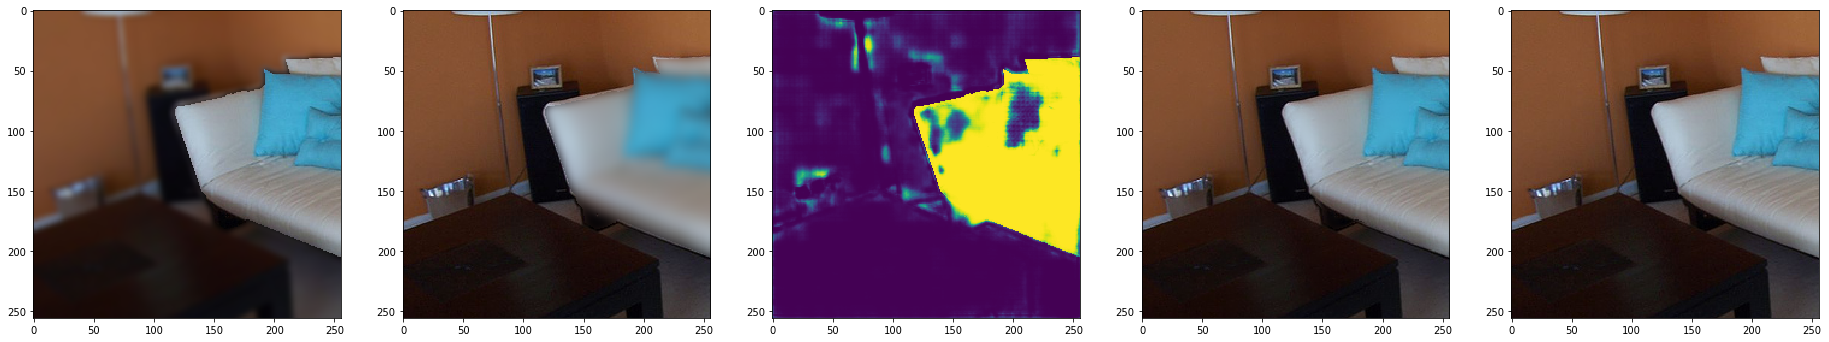

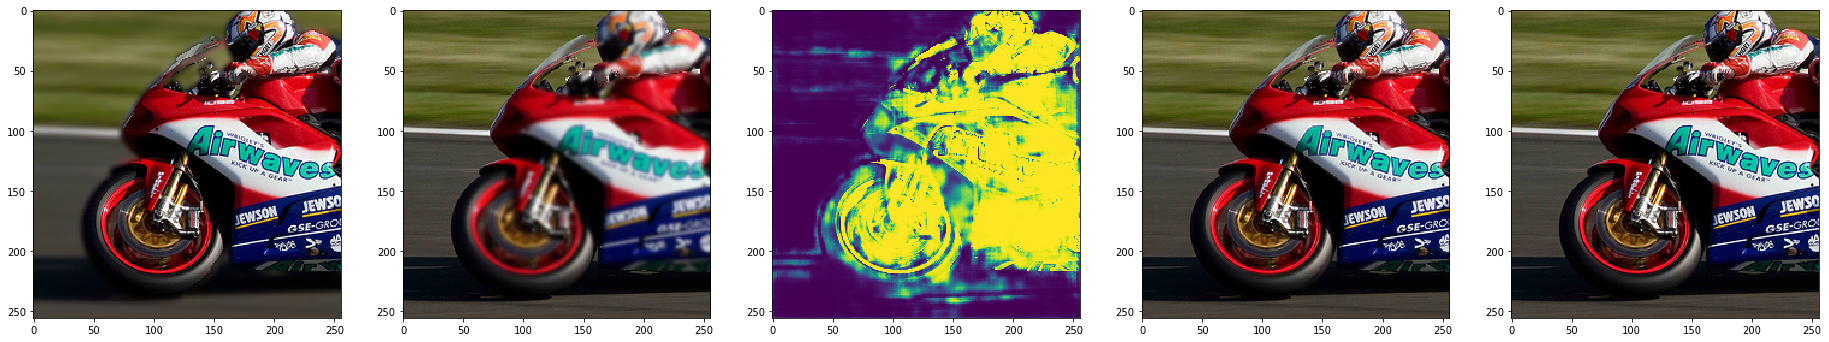

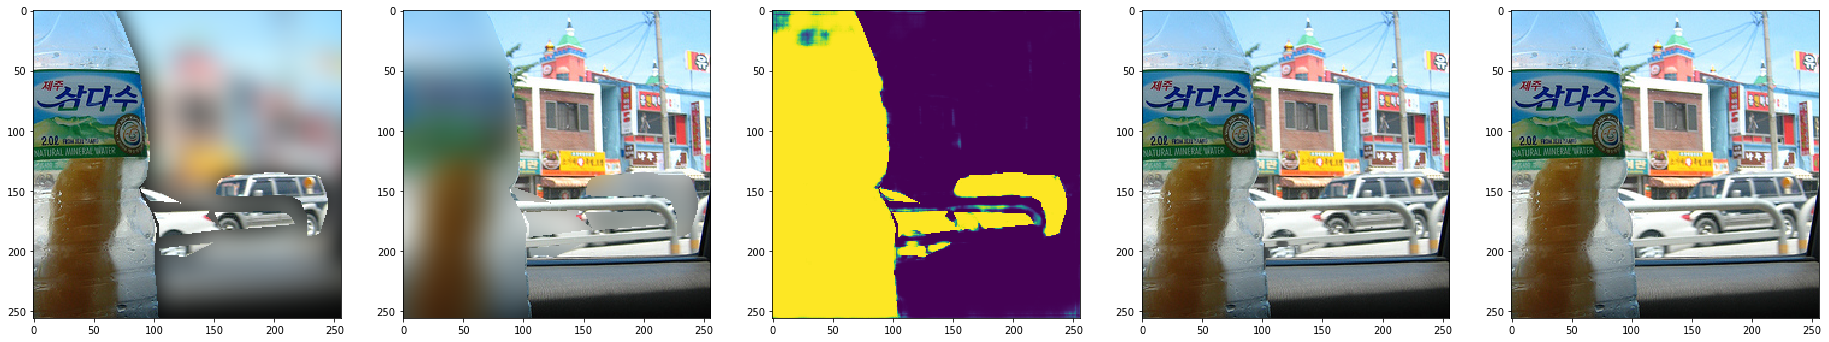

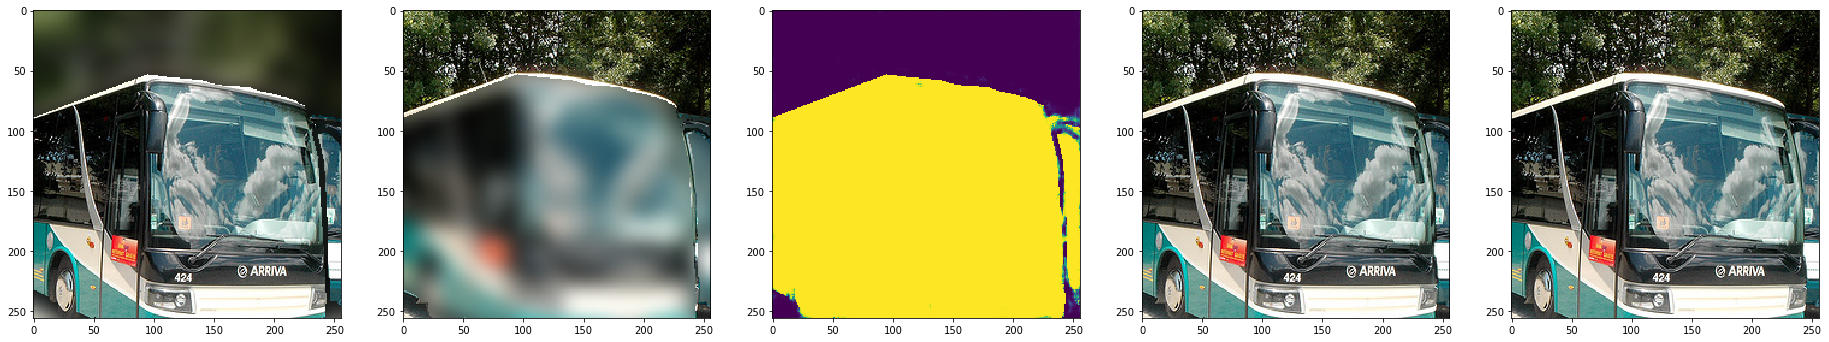

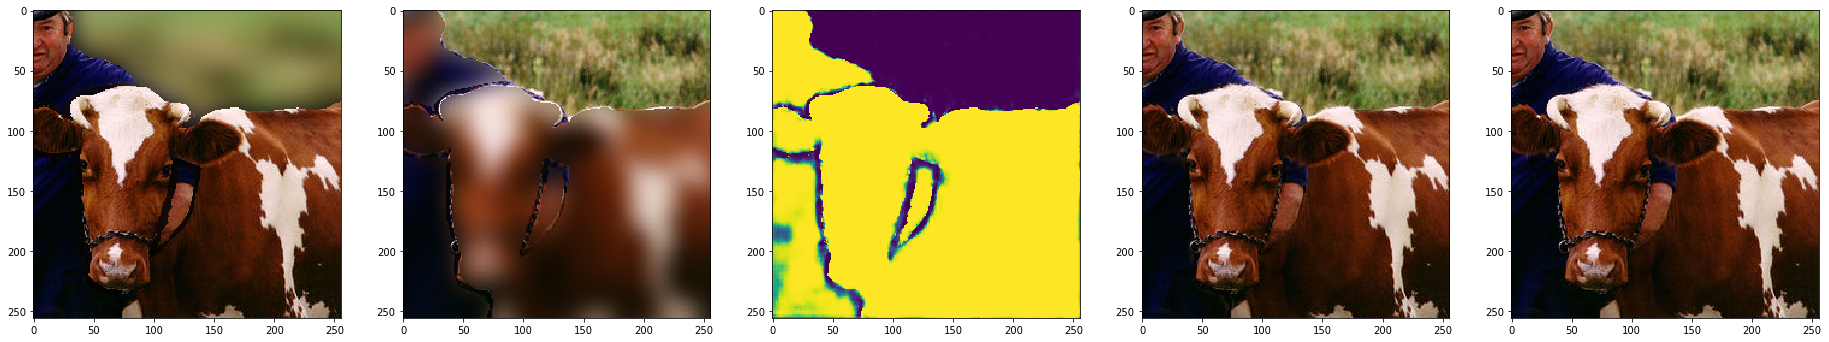

In [25]:
# prediction= generator.predict([x_test1[:25, :, :, :]/127.5-1, x_test2[:25, :, :, :]/127.5-1])#, y_test[:25, :, :, :]/127.5-1)
for imgIdx in range(5):
    fig=plt.figure(figsize=(32, 32))
    columns = 5
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(x_test1[imgIdx, :, :, ::-1])
    fig.add_subplot(rows, columns, 2)
    plt.imshow(x_test2[imgIdx, :, :, ::-1])
    fig.add_subplot(rows, columns, 3)
    plt.imshow((layer_output[imgIdx, :, :, 0]+1)/2)
    fig.add_subplot(rows, columns, 4)
    plt.imshow((prediction[imgIdx, :, :, ::-1]+1)/2)
    fig.add_subplot(rows, columns, 5)
    plt.imshow(y_test[imgIdx, :, :, ::-1])
    plt.show()   

In [26]:
# def load_images_from_folder(folder):
#     images = []
#     for filename in os.listdir(folder):
#         if 'aif' in filename:
#             continue         
#         print(filename)
#         img = cv2.imread(os.path.join(folder,filename))

#         if img is not None:
#             #img = cv2.resize(img, (0,0), fx = 0.5, fy = 0.5)
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             images.append(img)
#     return images

# dataPath = "stacks/"
# for filename in os.listdir(dataPath):
#     print(filename)

#     dataPath_curr = dataPath + filename + "/";
#     focal_stack = load_images_from_folder(dataPath_curr)
#     print(len(focal_stack))
#     #focal_stack = focal_stack[:3]
#     dataNum = 1

#     prediction = focal_stack[0][np.newaxis, :, :, :]/127.5-1

#     for img in focal_stack:
#         x_test1 = prediction
#         x_test2 = img[np.newaxis, :, :, :]/127.5-1

#         prediction= generator.predict([x_test1, x_test2])
#   #   get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
#   #                                     [generator.layers[-2].output])

#   #   layer_output = np.array(get_layer_output([x_test1/127.5-1, x_test2/127.5-1])[0])
  
#     I0=(prediction[0, :, :, :]+1)/2
#     plt.imshow(I0)
#     plt.show()
#     cv2.imwrite(dataPath_curr + 'aif.jpg',cv2.cvtColor((I0*255).astype('uint8'), cv2.COLOR_RGB2BGR))

In [27]:
# from keras.models import load_model
# generator = load_model('models/083-0.00027.hdf5')